In [150]:
#Import all the necessary libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import re
import plotly.express as px
from collections import defaultdict
import plotly.io as pio
import json
import plotly.graph_objs as go
import matplotlib.colors as mcolors
import json
import ipywidgets as widgets
import warnings
import time

In [151]:
import os
import shutil

def create_subdirectory():
    """
    Filters .mzML files from the given source subdirectory (located within Projects folder)
    and moves them into appropriate subfolders ('o3on' or 'o2only') based on file names.
    """

    while True:
        # Ask user for the source subdirectory (e.g. "04_29_23/mzml")
        src_subdirectory = input("Enter the source subdirectory (e.g. '04_29_23/mzml'): ")

        # Ensure source subdirectory is within Projects folder
        src_directory = os.path.join("Projects", src_subdirectory)

        # Check if the source directory exists
        if os.path.exists(src_directory):
            user_input = input(f"The directory '{src_directory}' already exists. type y to exit | type n to try another name | (y/n): ").strip().lower()
            if user_input != 'y':
                print("Please enter a different directory.")
                continue
        else:
            print(f"The directory '{src_directory}' does not exist. I am creating it. Meow.")
            os.makedirs(src_directory)

        # Set the destination directories for o3on and o2only
        dst_directory_o3on = os.path.join(src_directory, "o3on")
        dst_directory_o2only = os.path.join(src_directory, "o2only")

        # Create the destination directories if they don't exist
        os.makedirs(dst_directory_o3on, exist_ok=True)
        os.makedirs(dst_directory_o2only, exist_ok=True)

        # Loop through the files in the source directory
        for filename in os.listdir(src_directory):
            # Check if the file ends with ".mzML"
            if filename.endswith(".mzML"):
                # Determine which folder to move the file to based on its name
                if "_o3on.mzML" in filename:
                    shutil.move(os.path.join(src_directory, filename), os.path.join(dst_directory_o3on, filename))
                elif "_o2only.mzML" in filename:
                    shutil.move(os.path.join(src_directory, filename), os.path.join(dst_directory_o2only, filename))
        break

# Example Usage:
create_subdirectory()

In [152]:
def pre_parsing_setup():
    # Defaults
    data_base_name_location = 'lipid_database/Lipid_Database.xlsx'
    Project = './Projects/'
    Project_Name = 'canola'
    Project_Folder_data = Project + Project_Name + '/mzml/o3on/'
    Project_results = Project + Project_Name + '/results/'
    file_name_to_save = 'canola'
    tolerance = 0.3
    remove_std = True
    save_data = True
    
    # Ask if user wants to use all default settings
    use_defaults = input("Use default settings? (y/n): ").strip().lower()

    # If not using defaults, ask for custom input for each variable
    if use_defaults != 'y':
        custom_db = input(f"Use default database location '{data_base_name_location}'? (y/n): ").strip().lower()
        if custom_db == 'n':
            data_base_name_location = input("Enter custom database location: ").strip()

        custom_project = input(f"Use default project '{Project}'? (y/n): ").strip().lower()
        if custom_project == 'n':
            Project = input("Enter custom project: ").strip()

        custom_project_name = input(f"Use default project name '{Project_Name}'? (y/n): ").strip().lower()
        if custom_project_name == 'n':
            Project_Name = input("Enter custom project name: ").strip()

        Project_Folder_data = Project + Project_Name + '/mzml/o3on/'
        Project_results = Project + Project_Name + '/results/'

        custom_folder_save = input(f"Use default project results '{Project_results}'? (y/n): ").strip().lower()
        if custom_folder_save == 'n':
            Project_results = input("Enter custom folder name for project results: ").strip()

        custom_file_save = input(f"Use default file name to save results '{file_name_to_save}'? (y/n): ").strip().lower()
        if custom_file_save == 'n':
            file_name_to_save = input("Enter custom file name to save results: ").strip()

        custom_tolerance = input(f"Use default tolerance '{tolerance}'? (y/n): ").strip().lower()
        if custom_tolerance == 'n':
            tolerance = float(input("Enter custom tolerance: ").strip())

        custom_remove_std = input(f"Use default remove_std setting '{remove_std}'? (y/n): ").strip().lower()
        if custom_remove_std == 'n':
            remove_std = input("Enter custom remove_std (True/False): ").strip().lower() == 'true'

        custom_save_data = input(f"Use default save_data setting '{save_data}'? (y/n): ").strip().lower()
        if custom_save_data == 'n':
            save_data = input("Enter custom save_data (True/False): ").strip().lower() == 'true'

    # Return all configurations as a dictionary
    # Return all configurations as a dictionary
    return {
        "data_base_name_location": data_base_name_location,
        "Project": Project,
        "Project_Name": Project_Name,
        "Project_Folder_data": Project_Folder_data,
        "Project_results": Project_results,
        "file_name_to_save": file_name_to_save,
        "tolerance": tolerance,
        "remove_std": remove_std,
        "save_data": save_data
    }

In [153]:
###All functions


def read_mrm_list(filename, remove_std=True, deuterated=False):
    mrm_list_new = pd.read_excel(filename, sheet_name=None)
    mrm_list_new = pd.concat(mrm_list_new, ignore_index=True)
    mrm_list_official = mrm_list_new[['Compound Name', 'Parent Ion', 'Product Ion', 'Class']]
    mrm_list_official.columns = mrm_list_official.columns.str.replace(' ', '_')
    mrm_list_official['Parent_Ion'] = np.round(mrm_list_official['Parent_Ion'], 1)
    mrm_list_official['Product_Ion'] = np.round(mrm_list_official['Product_Ion'], 1)
    mrm_list_official['Transition'] = mrm_list_official['Parent_Ion'].astype(str) + ' -> ' + mrm_list_official['Product_Ion'].astype(str)
    mrm_list_official = mrm_list_official.rename(columns={'Compound_Name': 'Lipid'})

    if remove_std:
        lipid_class_to_keep = ['PS', 'PG', 'CE', 'PC', 'DAG', 'PE', 'TAG', 'FA', 'Cer', 'CAR', 'PI', 'SM']
        mrm_list_official = mrm_list_official[mrm_list_official['Class'].isin(lipid_class_to_keep)]
    
    if deuterated:
        mrm_list_official['Parent_Ion'] += 1
        mrm_list_official['Product_Ion'] += 1
        # Update the Transition column with the updated values
        mrm_list_official['Transition'] = mrm_list_official['Parent_Ion'].astype(str) + ' -> ' + mrm_list_official['Product_Ion'].astype(str)
    
    return mrm_list_official



# Function to create an ion dictionary from an MRM database DataFrame
def create_ion_dict(mrm_database):
    ion_dict = defaultdict(list)
    # Iterate through the rows of the MRM database DataFrame
    for index, row in mrm_database.iterrows():
        # Add a tuple with Lipid and Class to the ion dictionary using Parent_Ion and Product_Ion as the key
        ion_dict[(row['Parent_Ion'], row['Product_Ion'])].append((row['Lipid'], row['Class']))
    return ion_dict

### New way to parse OzESI data
OzESI_time_df = pd.DataFrame(columns=['Lipid', 'Parent_Ion', 'Product_Ion', 'Intensity', 'Transition', 'Class', 'Sample_ID', 'Retention_Time', 'OzESI_Intensity'])
time_and_intensity_df = pd.DataFrame(columns=['Time', 'Intensity'])

def mzml_parser(file_name):
    global OzESI_time_df  # Declare OzESI_time_df as a global variable
    global time_and_intensity_df
    

    rows = []
    ozesi_rows = []
    
    data_folder = os.listdir(file_name)
    data_folder.sort()
    path_to_mzml_files = file_name

    for file in data_folder:
        if file.endswith('.mzML'):
            run = pymzml.run.Reader(path_to_mzml_files + file, skip_chromatogram=False)
            q1_mz = 0
            q3_mz = 0

            for spectrum in run:
                for element in spectrum.ID.split(' '):
                    if 'Q1' in element:
                        q1 = element.split('=')
                        q1_mz = np.round(float(q1[1]), 1)
                    
                    if 'Q3' in element:
                        q3 = element.split('=')
                        q3_mz = np.round(float(q3[1]), 1)

                        #####checking (TG 52:2) 876.6 -> 577.6  specifically for the OzESI data
                        #####################################################################
                        if within_tolerance(q1_mz, 876.6) and within_tolerance(q3_mz, 577.6):  # Check if parent ion and product ion match target values
                            for time, intensity in spectrum.peaks():
                                # Append the time and intensity data for the target ions to the DataFrame
                                time_and_intensity_df = time_and_intensity_df.append({
                                    'Time': time,
                                    'Intensity': intensity
                                }, ignore_index=True)
                            times, intensities = zip(*spectrum.peaks())
                            plt.plot(times, intensities)
                            plt.xlabel('Time')
                            plt.ylabel('Intensity')
                            plt.title('Chromatogram for 876.6 -> 577.6')
                            plt.show()
                        ####################################################################
                        
                        intensity_store = np.array([intensity for _, intensity in spectrum.peaks()])
                        intensity_sum = np.sum(intensity_store)
                        
                        transition = f"{q1_mz} -> {q3_mz}"
                        sample_id = file[:-5]
                        
                        rows.append({
                            'Parent_Ion': q1_mz,
                            'Product_Ion': q3_mz,
                            'Intensity': intensity_sum,
                            'Transition': transition,
                            'Sample_ID': sample_id
                        })
                        
                        for time, intensity in spectrum.peaks():
                            ozesi_rows.append({
                                'Parent_Ion': q1_mz,
                                'Product_Ion': q3_mz,
                                'Retention_Time': time,
                                'OzESI_Intensity': intensity,
                                'Sample_ID': sample_id,
                                'Transition': transition
                            })
                           
     

    df = pd.DataFrame(rows)
    OzESI_time_df = pd.DataFrame(ozesi_rows)
    print('Finished parsing mzML files\n')
    return df


# Function to check if the absolute difference between two values is within a given tolerance
def within_tolerance(a, b, tolerance=0.3):
    return abs(a - b) <= tolerance

# Function to match the ions in a DataFrame row with the ions in an ion dictionary
def match_ions(row, ion_dict, tolerance=0.3):
    ions = (row['Parent_Ion'], row['Product_Ion'])
    matched_lipids = []
    matched_classes = []

    # Iterate through the ion dictionary
    for key, value in ion_dict.items():
        # Check if both the Parent_Ion and Product_Ion values are within the specified tolerance
        if within_tolerance(ions[0], key[0], tolerance) and within_tolerance(ions[1], key[1], tolerance):
            # If within tolerance, extend the matched_lipids and matched_classes lists with the corresponding values
            matched_lipids.extend([match[0] for match in value])
            matched_classes.extend([match[1] for match in value])

    # If any matches were found, update the Lipid and Class columns in the row
    if matched_lipids and matched_classes:
        row['Lipid'] = ' | '.join(matched_lipids)
        row['Class'] = ' | '.join(matched_classes)

    return row

####Combined functions for Matching

def match_lipids_parser(mrm_database,df, tolerance=0.3):
    ion_dict = create_ion_dict(mrm_database)
    # Assuming you have the df DataFrame to apply the match_ions function
    df_matched = df.apply(lambda row: match_ions(row, ion_dict=ion_dict, tolerance=tolerance), axis=1)


    # df_matched = df_matched.dropna()
    
    return df_matched


def save_dataframe(df, Project_results, file_name_to_save, max_attempts=5):
    folder_path = f'data_results/data/data_matching/{Project_results}'
    os.makedirs(folder_path, exist_ok=True)

    for i in range(max_attempts):
        file_path = f'{folder_path}/{file_name_to_save}.csv'
        if not os.path.isfile(file_path):
            df.to_csv(file_path, index=False)
            print(f"Saved DataFrame to {file_path}")
            break
    else:
        print(f"Failed to save DataFrame after {max_attempts} attempts.")
        return None



def full_parse(data_base_name_location, Project_Folder_data, Project_results, file_name_to_save, tolerance, remove_std=True, save_data=False):
    mrm_database = read_mrm_list(data_base_name_location, remove_std=remove_std)
    df = mzml_parser(Project_Folder_data)
    df_matched = match_lipids_parser(mrm_database, df, tolerance=tolerance)
    
    if save_data:
        save_dataframe(df_matched, Project_results, file_name_to_save)

    return df_matched

/tmp/ipykernel_23624/168002782.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_23624/168002782.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_23624/168002782.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2

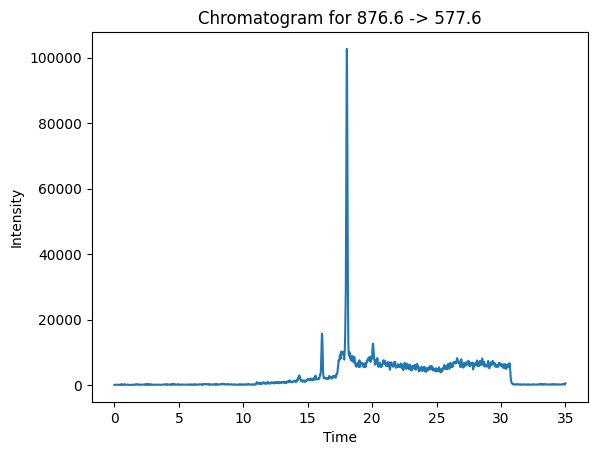

/tmp/ipykernel_23624/168002782.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_23624/168002782.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_23624/168002782.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_23624/168002782.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_23624/168002782.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_23624/168002782.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

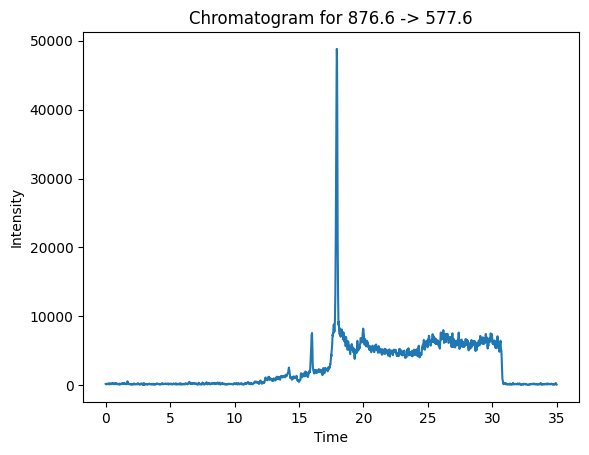

/tmp/ipykernel_23624/168002782.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_23624/168002782.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_23624/168002782.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_23624/168002782.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_23624/168002782.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_23624/168002782.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future

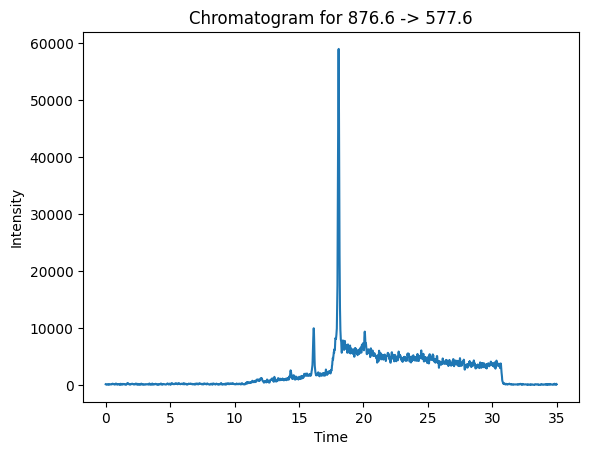

Finished parsing mzML files

Failed to save DataFrame after 5 attempts.


In [154]:
# First, get configurations from pre_parsing_setup
configurations = pre_parsing_setup()

# Now, extract the values from the configurations dictionary
data_base_name_location = configurations['data_base_name_location']
Project_Folder_data = configurations['Project_Folder_data']
Project_results = configurations['Project_results']
file_name_to_save = configurations['file_name_to_save']
tolerance = configurations['tolerance']
remove_std = configurations['remove_std']
save_data = configurations['save_data']

# Now call the full_parse function with the extracted variables
df_matched = full_parse(data_base_name_location, 
                        Project_Folder_data, 
                        Project_results, 
                        file_name_to_save, 
                        tolerance, remove_std, save_data)

In [155]:
time_and_intensity_df.nlargest(20, 'Intensity')
# time_and_intensity_df.head()



,Time,Intensity
1106,18.039483,102684.304688
1107,18.055800,97655.070312
1105,18.023183,93488.468750
1108,18.072100,84132.226562
1104,18.006867,79498.382812
1109,18.088417,63933.003906
5403,18.088400,58975.664062
5402,18.072100,58766.042969
1103,17.990567,58047.804688
5401,18.055800,53428.363281


In [156]:
df_matched.head(None)
OzESI_time_df.head(None)

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,760.6,571.6,0.015933,190.400009,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
1,760.6,571.6,0.032233,147.420013,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
2,760.6,571.6,0.048550,153.620010,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
3,760.6,571.6,0.064850,200.080017,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
4,760.6,571.6,0.081167,206.900009,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
...,...,...,...,...,...,...
225352,904.8,605.6,34.931700,148.500015,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6
225353,904.8,605.6,34.948000,131.800003,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6
225354,904.8,605.6,34.964317,151.960007,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6
225355,904.8,605.6,34.980617,137.700012,RBDCanola_O3on_150gN3_02082023,904.8 -> 605.6


In [157]:
# Filtering the DataFrame for the specified Parent_Ion and Product_Ion
filtered_df_52_2 = OzESI_time_df[(OzESI_time_df['Parent_Ion'] == 872.8) & 
                                 (OzESI_time_df['Product_Ion'] == 573.6) & 
                                 (OzESI_time_df['OzESI_Intensity'] >10000) & 
                                 (OzESI_time_df['Retention_Time'] >14) &
                                 (OzESI_time_df['Retention_Time'] <15)]

# # Filtering the DataFrame for the specified Parent_Ion and Product_Ion
# filtered_df_52_2 = OzESI_time_df[(OzESI_time_df['Parent_Ion'] == 872.8) & 
#                                  (OzESI_time_df['Product_Ion'] == 573.6) & 
#                                  (OzESI_time_df['OzESI_Intensity'] >100)]

# Extracting the 'Retention_Time' column from the filtered DataFrame
retention_times_52_2 = filtered_df_52_2[['Retention_Time', 'OzESI_Intensity', 'Parent_Ion', 'Product_Ion']]


# You can print or otherwise use the retention_times Series here.
# For example, to print all the unique retention times for these ions:
retention_times_52_2.head(None)


,Retention_Time,OzESI_Intensity,Parent_Ion,Product_Ion
56672,14.289583,10193.100586,872.8,573.6
56673,14.305900,10840.960938,872.8,573.6
56674,14.322200,12424.000977,872.8,573.6
56675,14.338517,11457.701172,872.8,573.6
56676,14.354817,10338.701172,872.8,573.6


In [158]:
# Filtering the DataFrame for the specified Parent_Ion and Product_Ion
filtered_df_52_3 = OzESI_time_df[(OzESI_time_df['Parent_Ion'] == 874.8
) & (OzESI_time_df['Product_Ion'] == 575.6
) & (OzESI_time_df['OzESI_Intensity'] >40000)]

# Extracting the 'Retention_Time' column from the filtered DataFrame
retention_times_52_3 = filtered_df_52_3[['Retention_Time', 'OzESI_Intensity', 'Parent_Ion', 'Product_Ion']]


# You can print or otherwise use the retention_times Series here.
# For example, to print all the unique retention times for these ions:
retention_times_52_3.head(None)


,Retention_Time,OzESI_Intensity,Parent_Ion,Product_Ion


In [159]:
mrm_database = read_mrm_list(data_base_name_location)
tolerance = 0.3
df_oz_matched = match_lipids_parser(mrm_database, OzESI_time_df, tolerance)

/tmp/ipykernel_23624/168002782.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_23624/168002782.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_23624/168002782.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [160]:
def filter_rt(df):
    """
    Filters the DataFrame based on retention times and aggregates by max intensity for unique 'Sample_ID' and 'Transition' combinations.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with columns 'Retention_Time' and 'OzESI_Intensity'.
        
    Returns:
        pd.DataFrame: Filtered and aggregated DataFrame.
    """
    # Filter based on retention time
    filtered_df = df[(df['Retention_Time'] > 14.0) & (df['Retention_Time'] < 21.0)].copy()

    # Round the values
    filtered_df['Retention_Time'] = filtered_df['Retention_Time'].round(2)
    filtered_df['OzESI_Intensity'] = filtered_df['OzESI_Intensity'].round(0)

    # Aggregate by max intensity for unique combinations of 'Sample_ID' and 'Transition'
    filtered_df = filtered_df.groupby(['Sample_ID', 'Transition']).apply(
        lambda x: x.loc[x['OzESI_Intensity'].idxmax()]).reset_index(drop=True)

    return filtered_df


filtered_df = filter_rt(df_oz_matched)
filtered_df.head(50)

,Class,Lipid,OzESI_Intensity,Parent_Ion,Product_Ion,Retention_Time,Sample_ID,Transition
0,NaN,NaN,433.0,760.6,571.6,18.22,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6
1,NaN,NaN,1875.0,762.6,573.6,14.30,CrudeCanola_O3on_150gN3_02082023,762.6 -> 573.6
2,NaN,NaN,3420.0,764.6,575.6,16.09,CrudeCanola_O3on_150gN3_02082023,764.6 -> 575.6
3,NaN,NaN,16153.0,766.7,577.6,18.05,CrudeCanola_O3on_150gN3_02082023,766.7 -> 577.6
4,NaN,NaN,671.0,782.6,593.6,20.46,CrudeCanola_O3on_150gN3_02082023,782.6 -> 593.6
5,NaN,NaN,510.0,784.6,595.6,19.88,CrudeCanola_O3on_150gN3_02082023,784.6 -> 595.6
6,NaN,NaN,406.0,786.6,569.6,19.55,CrudeCanola_O3on_150gN3_02082023,786.6 -> 569.6
7,NaN,NaN,553.0,786.6,597.6,19.42,CrudeCanola_O3on_150gN3_02082023,786.6 -> 597.6
8,NaN,NaN,308.0,788.6,571.6,14.30,CrudeCanola_O3on_150gN3_02082023,788.6 -> 571.6
9,NaN,NaN,5259.0,788.6,599.6,14.31,CrudeCanola_O3on_150gN3_02082023,788.6 -> 599.6


In [161]:
# Filtering the DataFrame for the specified Parent_Ion and Product_Ion
filtered_df_52_3b = OzESI_time_df[(OzESI_time_df['Parent_Ion'] == 874.8
) & (OzESI_time_df['Product_Ion'] == 575.6
) & (OzESI_time_df['OzESI_Intensity'] >40000)]

# Extracting the 'Retention_Time' column from the filtered DataFrame
retention_times_52_3b = filtered_df_52_3b['Retention_Time']

# You can print or otherwise use the retention_times Series here.
# For example, to print all the unique retention times for these ions:
retention_times_52_3b.head(None)


Series([], Name: Retention_Time, dtype: float64)

In [162]:
def concat_dataframes(df_matched, filtered_df):
    """
    Concatenates two DataFrames along the columns.
    
    Parameters:
        df_matched (pd.DataFrame): First DataFrame.
        filtered_df (pd.DataFrame): Second DataFrame, only the 'Retention_Time' and 'OzESI_Intensity' columns will be used.
        
    Returns:
        pd.DataFrame: Concatenated DataFrame.
    """
    return pd.concat([df_matched, filtered_df[['Retention_Time', 'OzESI_Intensity']]], axis=1)

df_matched_2 = concat_dataframes(df_matched, filtered_df)
df_matched_2.head(None)

,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition,Retention_Time,OzESI_Intensity
0,NaN,5.451378e+05,NaN,760.6,571.6,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6,18.22,433.0
1,NaN,6.208219e+05,NaN,762.6,573.6,CrudeCanola_O3on_150gN3_02082023,762.6 -> 573.6,14.30,1875.0
2,NaN,9.441859e+05,NaN,764.6,575.6,CrudeCanola_O3on_150gN3_02082023,764.6 -> 575.6,16.09,3420.0
3,NaN,1.137434e+06,NaN,766.7,577.6,CrudeCanola_O3on_150gN3_02082023,766.7 -> 577.6,18.05,16153.0
4,NaN,5.900676e+05,NaN,782.6,593.6,CrudeCanola_O3on_150gN3_02082023,782.6 -> 593.6,20.46,671.0
...,...,...,...,...,...,...,...,...,...
100,TAG,4.897507e+05,[TG(54:6)]_FA18:1,896.8,597.6,RBDCanola_O3on_150gN3_02082023,896.8 -> 597.6,18.02,297883.0
101,TAG,1.179904e+06,[TG(54:5)]_FA18:1,898.8,599.6,RBDCanola_O3on_150gN3_02082023,898.8 -> 599.6,20.04,37838.0
102,TAG,1.654774e+06,"[TG(55:11),TG(54:4)]_FA18:1",900.8,601.6,RBDCanola_O3on_150gN3_02082023,900.8 -> 601.6,NaN,NaN
103,TAG,5.234119e+06,"[TG(55:10),TG(54:3)]_FA18:1",902.8,603.6,RBDCanola_O3on_150gN3_02082023,902.8 -> 603.6,NaN,NaN


In [163]:
def DB_Position_df(df_matched_2, OzESI_list=[7,9,12]):
    """
    Creates a new DataFrame to store the DB_Position and Aldehyde_Ion values,
    and calculate n-i values for the given OzESI_list.
    
    Parameters:
        df_matched_2 (pd.DataFrame): Input DataFrame.
        OzESI_list (list): List of OzESI positions.
        
    Returns:
        pd.DataFrame: Modified DataFrame with new calculated columns.
    """
    # Create a new DataFrame to store the DB_Position and Aldehyde_Ion values
    df_DB_position = pd.DataFrame(columns=['DB_Position','Aldehyde_Ion'])

    # Loop over the range of DB_Position values and calculate the corresponding Aldehyde_Ion values
    for i in range(3, 21):
        df_DB_position.loc[i, 'DB_Position'] = i
        df_DB_position.loc[i, 'Aldehyde_Ion'] = 26 + (14 * (i-3))

    # Loop through OzESI_list
    for i in OzESI_list:
        # Retrieve the Aldehyde_Ion value for the current DB_Position
        aldehyde_ion = df_DB_position.loc[df_DB_position["DB_Position"] == i, "Aldehyde_Ion"].values[0]

        # Calculate n-i values
        df_matched_2["n-{}".format(i)] = df_matched_2["Parent_Ion"] - aldehyde_ion

    return df_matched_2

# Example usage:
df_matched_2 = DB_Position_df(df_matched_2, OzESI_list=[7,9,12])
df_matched_2.head(None)

,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition,Retention_Time,OzESI_Intensity,n-7,n-9,n-12
0,NaN,5.451378e+05,NaN,760.6,571.6,CrudeCanola_O3on_150gN3_02082023,760.6 -> 571.6,18.22,433.0,678.6,650.6,608.6
1,NaN,6.208219e+05,NaN,762.6,573.6,CrudeCanola_O3on_150gN3_02082023,762.6 -> 573.6,14.30,1875.0,680.6,652.6,610.6
2,NaN,9.441859e+05,NaN,764.6,575.6,CrudeCanola_O3on_150gN3_02082023,764.6 -> 575.6,16.09,3420.0,682.6,654.6,612.6
3,NaN,1.137434e+06,NaN,766.7,577.6,CrudeCanola_O3on_150gN3_02082023,766.7 -> 577.6,18.05,16153.0,684.7,656.7,614.7
4,NaN,5.900676e+05,NaN,782.6,593.6,CrudeCanola_O3on_150gN3_02082023,782.6 -> 593.6,20.46,671.0,700.6,672.6,630.6
...,...,...,...,...,...,...,...,...,...,...,...,...
100,TAG,4.897507e+05,[TG(54:6)]_FA18:1,896.8,597.6,RBDCanola_O3on_150gN3_02082023,896.8 -> 597.6,18.02,297883.0,814.8,786.8,744.8
101,TAG,1.179904e+06,[TG(54:5)]_FA18:1,898.8,599.6,RBDCanola_O3on_150gN3_02082023,898.8 -> 599.6,20.04,37838.0,816.8,788.8,746.8
102,TAG,1.654774e+06,"[TG(55:11),TG(54:4)]_FA18:1",900.8,601.6,RBDCanola_O3on_150gN3_02082023,900.8 -> 601.6,NaN,NaN,818.8,790.8,748.8
103,TAG,5.234119e+06,"[TG(55:10),TG(54:3)]_FA18:1",902.8,603.6,RBDCanola_O3on_150gN3_02082023,902.8 -> 603.6,NaN,NaN,820.8,792.8,750.8


In [164]:
#Make a new column for Labels of n-#
df_matched_2['Labels'] = ''
OzESI_list = [7, 9, 12]

def within_tolerance(a, b, tolerance=0.3):
    return abs(a - b) <= tolerance
columns = [
    'Lipid', 'Parent_Ion', 'Product_Ion', 'Intensity', 'Transition', 'Class',
    'Sample_ID', 'Retention_Time', 'Intensity_OzESI', 'Mean_Retention_Time',
    'Mean_Intensity_OzESI', 'n-7', 'n-9', 'n-12', 'Labels'
]
df_OzESI_n = pd.DataFrame(columns=columns)

#Function to add lipid name
def add_lipid_info(df_matched_2, OzESI_list, tolerance=0.3):
    df_test = df_matched_2.copy()
    df_test_2 = df_matched_2.copy()
    global df_OzESI_n
    
    for i in OzESI_list:
        df_test['n-' + str(i)] = df_test['n-' + str(i)].astype(float)
    
    for i in range(len(df_test)):
        if pd.isna(df_test.loc[i, 'Lipid']):
            parent_ion = df_test.loc[i, 'Parent_Ion']
            
            for j in range(len(df_test)):
                row_data = df_test.loc[j].copy()
                if within_tolerance(parent_ion, row_data['n-7'], tolerance) and isinstance(row_data['Lipid'], str):
                    df_test.loc[i, 'Lipid'] = row_data['Lipid']
                    df_test.loc[i, 'Labels'] = 'n-7' + row_data['Labels']
                    
                    # Append to df_test_2
                    appended_row = df_test.loc[i].copy()
                    appended_row['Labels'] = 'n-7' + row_data['Labels']
                    df_test_2 = df_test_2.append(appended_row, ignore_index=True)
                    
                elif within_tolerance(parent_ion, row_data['n-9'], tolerance) and isinstance(row_data['Lipid'], str):
                    df_test.loc[i, 'Lipid'] = row_data['Lipid']
                    df_test.loc[i, 'Labels'] = 'n-9' + row_data['Labels']
                    
                    # Append to df_test_2
                    appended_row = df_test.loc[i].copy()
                    appended_row['Labels'] = 'n-9' + row_data['Labels']
                    df_test_2 = df_test_2.append(appended_row, ignore_index=True)
                    
                elif within_tolerance(parent_ion, row_data['n-12'], tolerance) and isinstance(row_data['Lipid'], str):
                    df_test.loc[i, 'Lipid'] = row_data['Lipid']
                    df_test.loc[i, 'Labels'] = 'n-12' + row_data['Labels']
                    
                    # Append to df_test_2
                    appended_row = df_test.loc[i].copy()
                    appended_row['Labels'] = 'n-12' + row_data['Labels']
                    df_test_2 = df_test_2.append(appended_row, ignore_index=True)
    
    df_test_2.dropna(subset=['Lipid'], inplace=True)
    return df_test_2

#Add lipid name to df_matched 3
df_matched_3 = add_lipid_info(df_matched_2, OzESI_list, tolerance=0.3)

/tmp/ipykernel_23624/1324803894.py:45: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_23624/1324803894.py:36: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [165]:
df_matched_3_sorted = df_matched_3.sort_values(by=['Sample_ID','Product_Ion'])
df_matched_3_sorted.head(None)

,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition,Retention_Time,OzESI_Intensity,n-7,n-9,n-12,Labels
23,TAG,3.519442e+05,[TG(52:6)]_FA18:1,868.7,569.6,CrudeCanola_O3on_150gN3_02082023,868.7 -> 569.6,20.72,380.0,786.7,758.7,716.7,
24,TAG,3.477245e+05,[TG(52:6)]_FA18:1,868.7,569.6,CrudeCanola_O3on_150gN3_02082023,868.7 -> 569.6,14.50,348.0,786.7,758.7,716.7,
120,NaN,4.602300e+05,[TG(52:6)]_FA18:1,786.6,569.6,CrudeCanola_O3on_150gN3_02082023,786.6 -> 569.6,19.55,406.0,704.6,676.6,634.6,n-7
121,NaN,4.602300e+05,[TG(52:6)]_FA18:1,786.6,569.6,CrudeCanola_O3on_150gN3_02082023,786.6 -> 569.6,19.55,406.0,704.6,676.6,634.6,n-7
122,NaN,4.602300e+05,[TG(54:6)]_FA18:1,786.6,569.6,CrudeCanola_O3on_150gN3_02082023,786.6 -> 569.6,19.55,406.0,704.6,676.6,634.6,n-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,NaN,1.276374e+06,"[TG(53:9),TG(52:2)]_FA18:1",794.6,605.6,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,20.44,1183.0,712.6,684.6,642.6,n-7
377,NaN,1.276374e+06,"[TG(55:9),TG(54:2)]_FA18:1",794.6,605.6,RBDCanola_O3on_150gN3_02082023,794.6 -> 605.6,20.44,1183.0,712.6,684.6,642.6,n-9
399,NaN,7.742344e+05,"[TG(55:9),TG(54:2)]_FA18:1",822.7,605.6,RBDCanola_O3on_150gN3_02082023,822.7 -> 605.6,15.64,390.0,740.7,712.7,670.7,n-7
400,NaN,7.742344e+05,"[TG(55:9),TG(54:2)]_FA18:1",822.7,605.6,RBDCanola_O3on_150gN3_02082023,822.7 -> 605.6,15.64,390.0,740.7,712.7,670.7,n-7


In [166]:
df_matched_4 = df_matched_3_sorted.copy()
df_matched_4['Ratios'] = None



def calculate_intensity_ratio(df):
    # Create a new column for ratios
    df['Ratios'] = pd.Series(dtype='float64')

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        lipid = row['Lipid']
        label = row['Labels']
        intensity = row['OzESI_Intensity']
        sample_id = row['Sample_ID']

        # Check if the label is n-9
        if label == 'n-9':
            # Find the corresponding row with n-7 label and same lipid name
            n7_row = df[(df['Lipid'] == lipid) & (df['Labels'] == 'n-7')& (df['Sample_ID'] == sample_id)]

            # If a matching row is found, calculate the intensity ratio
            if not n7_row.empty:
                n7_intensity = n7_row['OzESI_Intensity'].values[0]
                ratio = intensity / n7_intensity

                # Assign the ratio to the 'Ratios' column
                df.at[index, 'Ratios'] = ratio

    return df

df_matched_4 = calculate_intensity_ratio(df_matched_4)

In [167]:
#filtering df_matched for name but not removing the n-7 ratios
def sort_by_second_tg(lipid):
    tgs = lipid.split(',')
    if len(tgs) > 1:
        return tgs[1]
    else:
        return lipid

df_matched_5 = df_matched_4.copy()
df_matched_5['Lipid'] = df_matched_5['Lipid'].apply(sort_by_second_tg)
df_matched_5.head(50)

,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition,Retention_Time,OzESI_Intensity,n-7,n-9,n-12,Labels,Ratios
23,TAG,3.519442e+05,[TG(52:6)]_FA18:1,868.7,569.6,CrudeCanola_O3on_150gN3_02082023,868.7 -> 569.6,20.72,380.0,786.7,758.7,716.7,,NaN
24,TAG,3.477245e+05,[TG(52:6)]_FA18:1,868.7,569.6,CrudeCanola_O3on_150gN3_02082023,868.7 -> 569.6,14.50,348.0,786.7,758.7,716.7,,NaN
120,NaN,4.602300e+05,[TG(52:6)]_FA18:1,786.6,569.6,CrudeCanola_O3on_150gN3_02082023,786.6 -> 569.6,19.55,406.0,704.6,676.6,634.6,n-7,NaN
121,NaN,4.602300e+05,[TG(52:6)]_FA18:1,786.6,569.6,CrudeCanola_O3on_150gN3_02082023,786.6 -> 569.6,19.55,406.0,704.6,676.6,634.6,n-7,NaN
122,NaN,4.602300e+05,[TG(54:6)]_FA18:1,786.6,569.6,CrudeCanola_O3on_150gN3_02082023,786.6 -> 569.6,19.55,406.0,704.6,676.6,634.6,n-9,0.743590
123,NaN,4.602300e+05,[TG(52:6)]_FA18:1,786.6,569.6,CrudeCanola_O3on_150gN3_02082023,786.6 -> 569.6,19.55,406.0,704.6,676.6,634.6,n-7,NaN
124,NaN,4.602300e+05,[TG(52:6)]_FA18:1,786.6,569.6,CrudeCanola_O3on_150gN3_02082023,786.6 -> 569.6,19.55,406.0,704.6,676.6,634.6,n-7,NaN
125,NaN,4.602300e+05,[TG(54:6)]_FA18:1,786.6,569.6,CrudeCanola_O3on_150gN3_02082023,786.6 -> 569.6,19.55,406.0,704.6,676.6,634.6,n-9,0.743590
126,NaN,4.602300e+05,[TG(52:6)]_FA18:1,786.6,569.6,CrudeCanola_O3on_150gN3_02082023,786.6 -> 569.6,19.55,406.0,704.6,676.6,634.6,n-7,NaN
127,NaN,4.602300e+05,[TG(52:6)]_FA18:1,786.6,569.6,CrudeCanola_O3on_150gN3_02082023,786.6 -> 569.6,19.55,406.0,704.6,676.6,634.6,n-7,NaN


In [168]:
# Iterate through each row in the DataFrame
for index, row in df_matched_5.iterrows():
    # Extract Lipid, Sample_ID, Labels and Ratios from the row
    lipid = row['Lipid']
    sample_id = row['Sample_ID']
    labels = row['Labels']
    ratios = row['Ratios']

    # Check if ratios is not NaN
    if not pd.isna(ratios):
        # Print out the values
        print(f'Lipid: {lipid}, Sample_ID: {sample_id}, Labels: {labels}, Ratios: {ratios}')

Lipid: [TG(54:6)]_FA18:1, Sample_ID: CrudeCanola_O3on_150gN3_02082023, Labels: n-9, Ratios: 0.7435897435897436
Lipid: [TG(54:6)]_FA18:1, Sample_ID: CrudeCanola_O3on_150gN3_02082023, Labels: n-9, Ratios: 0.7435897435897436
Lipid: [TG(54:6)]_FA18:1, Sample_ID: CrudeCanola_O3on_150gN3_02082023, Labels: n-9, Ratios: 0.7435897435897436
Lipid: [TG(52:5)]_FA18:1, Sample_ID: CrudeCanola_O3on_150gN3_02082023, Labels: n-9, Ratios: 1.405844155844156
Lipid: [TG(52:5)]_FA18:1, Sample_ID: CrudeCanola_O3on_150gN3_02082023, Labels: n-9, Ratios: 1.405844155844156
Lipid: [TG(52:5)]_FA18:1, Sample_ID: CrudeCanola_O3on_150gN3_02082023, Labels: n-9, Ratios: 1.405844155844156
Lipid: [TG(54:5)]_FA18:1, Sample_ID: CrudeCanola_O3on_150gN3_02082023, Labels: n-9, Ratios: 0.23931623931623933
Lipid: [TG(54:5)]_FA18:1, Sample_ID: CrudeCanola_O3on_150gN3_02082023, Labels: n-9, Ratios: 0.23931623931623933
Lipid: [TG(54:5)]_FA18:1, Sample_ID: CrudeCanola_O3on_150gN3_02082023, Labels: n-9, Ratios: 0.23931623931623933
L

In [169]:
def filter_highest_ratios(df):
    # Sort the DataFrame by ratios in descending order
    df_sorted = df.sort_values(by='Ratios', ascending=False)

    # Drop duplicates keeping the first occurrence (highest ratio)
    df_filtered = df_sorted.drop_duplicates(subset=['Sample_ID', 'Lipid','Labels'], keep='first')
    df_filtered = df_filtered.sort_values(by=['Sample_ID', 'Lipid'], ascending=[True, True])

    return df_filtered

df_matched_6 = filter_highest_ratios(df_matched_5)

In [170]:
df_matched_6.head(None)

,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition,Retention_Time,OzESI_Intensity,n-7,n-9,n-12,Labels,Ratios
115,NaN,1.137434e+06,TG(52:2)]_FA18:1,766.7,577.6,CrudeCanola_O3on_150gN3_02082023,766.7 -> 577.6,18.05,16153.0,684.7,656.7,614.7,n-9,4.234076
28,TAG,6.697262e+06,TG(52:2)]_FA18:1,876.8,577.6,CrudeCanola_O3on_150gN3_02082023,876.8 -> 577.6,17.55,2458.0,794.8,766.8,724.8,,NaN
180,NaN,7.481025e+05,TG(52:2)]_FA18:1,794.7,577.6,CrudeCanola_O3on_150gN3_02082023,794.7 -> 577.6,18.05,3815.0,712.7,684.7,642.7,n-7,NaN
113,NaN,9.441859e+05,TG(52:3)]_FA18:1,764.6,575.6,CrudeCanola_O3on_150gN3_02082023,764.6 -> 575.6,16.09,3420.0,682.6,654.6,612.6,n-9,3.157895
27,TAG,3.785085e+06,TG(52:3)]_FA18:1,874.8,575.6,CrudeCanola_O3on_150gN3_02082023,874.8 -> 575.6,18.04,102684.0,792.8,764.8,722.8,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,TAG,1.179904e+06,[TG(54:5)]_FA18:1,898.8,599.6,RBDCanola_O3on_150gN3_02082023,898.8 -> 599.6,20.04,37838.0,816.8,788.8,746.8,,NaN
390,NaN,5.576238e+05,[TG(54:5)]_FA18:1,816.7,599.6,RBDCanola_O3on_150gN3_02082023,816.7 -> 599.6,18.01,11771.0,734.7,706.7,664.7,n-7,NaN
332,NaN,5.748725e+05,[TG(54:6)]_FA18:1,786.6,597.6,RBDCanola_O3on_150gN3_02082023,786.6 -> 597.6,14.33,3415.0,704.6,676.6,634.6,n-9,0.959270
100,TAG,4.897507e+05,[TG(54:6)]_FA18:1,896.8,597.6,RBDCanola_O3on_150gN3_02082023,896.8 -> 597.6,18.02,297883.0,814.8,786.8,744.8,,NaN


In [171]:
import plotly.express as px
import os

# Create the "Plots" directory if it doesn't exist
os.makedirs("Projects/canola/plots/", exist_ok=True)


# Define color mappings for Lipid patterns
color_mapping = {
    '50': 'red',
    '51': 'brown',
    '52': 'blue',
    '53': 'purple',
    '54': 'green',
}

# Get the unique Sample_IDs
sample_ids = df_matched_6['Sample_ID'].unique()

# Loop over the unique Sample_IDs
for sample_id in sample_ids:
    
    # Filter the dataframe for the current Sample_ID
    df_sample = df_matched_6[df_matched_6['Sample_ID'] == sample_id]
    
    # Assign colors to Lipids based on patterns
    lipid_colors = []
    for lipid in df_sample['Lipid']:
        color = 'gray'  # Default color
        for pattern, pattern_color in color_mapping.items():
            if pattern in lipid:
                color = pattern_color
                break
        lipid_colors.append(color)
    
    # Create the bar plot
    fig = px.bar(df_sample, x='Lipid', y='Ratios', text='Ratios', title=f'Bar Plot for Sample_ID: {sample_id}',
                 color_discrete_map=color_mapping)
    
    # Apply colors to the bars
    fig.update_traces(
        marker_color=lipid_colors,
        texttemplate='%{text:.2f}',
        textposition='auto',
        marker_line_width=0
    )
    
    # Customize the layout
    fig.update_layout(
        uniformtext_minsize=18,
        uniformtext_mode='hide',
        xaxis=dict(
            title='Lipid',
            titlefont=dict(size=16)
        ),
        yaxis=dict(
            title='Ratios',
            titlefont=dict(size=16),
            tickfont=dict(size=16)  # Set the font size of y-axis labels
        ),
        legend=dict(
            title='Lipid Patterns',
            tracegroupgap=50,
            itemsizing='constant'
        ),
        title=dict(
            text=f'Sample_ID: {sample_id}',
            font=dict(size=20)  # Set the title font size
        )
    )
    # Save the plot as an image
    file_name = f"Projects/canola/plots/plot_{sample_id}.png"

    # Check if the file already exists
    index = 1
    while os.path.exists(file_name):
        file_name = f"Projects/canola/plots/plot_{sample_id}_{index}.png"
        index += 1

    fig.write_image(file_name)
    # Show plot
    fig.show()

comparison_of_Crude_n-9_n-7.png saved!


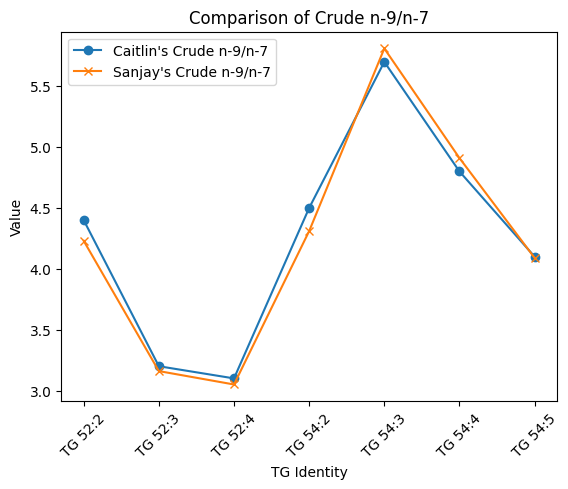

comparison_of_Degummed_n-9_n-7.png saved!


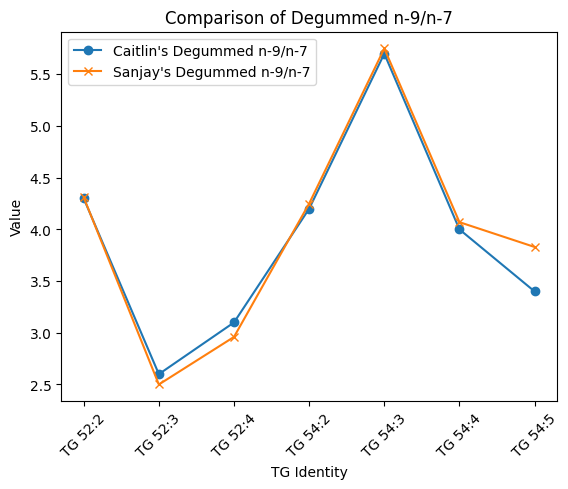

comparison_of_RBD_n-9_n-7.png saved!


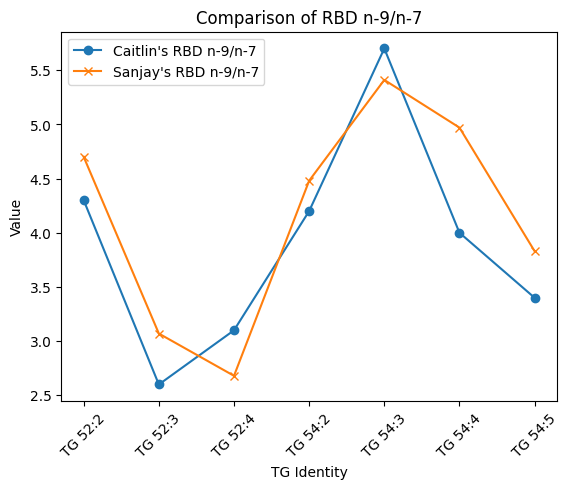

<Figure size 640x480 with 0 Axes>

In [174]:
import pandas as pd
import matplotlib.pyplot as plt

# Caitlin's Data
caitlin_data = {
    'TG Identity': ['TG 52:2', 'TG 52:3', 'TG 52:4', 'TG 54:2', 'TG 54:3', 'TG 54:4', 'TG 54:5'],
    'RT (min)': [18, 16.1, 14.4, 20, 18, 16.1, 14.3],
    'Crude n-9/n-7': [4.4, 3.2, 3.1, 4.5, 5.7, 4.8, 4.1],
    'Degummed n-9/n-7': [4.3, 2.6, 3.1, 4.2, 5.7, 4, 3.4],
    'RBD n-9/n-7': [4.3, 2.6, 3.1, 4.2, 5.7, 4, 3.4],
}
caitlin_df = pd.DataFrame(caitlin_data)

# Sanjay's Data
sanjay_data = {
    'TG Identity': ['TG 52:2', 'TG 52:3', 'TG 52:4', 'TG 54:2', 'TG 54:3', 'TG 54:4', 'TG 54:5'],
    'Crude n-9/n-7': [4.23, 3.16, 3.05, 4.31, 5.81, 4.91, 4.09],
    'Degummed n-9/n-7': [4.31, 2.5, 2.96, 4.25, 5.75, 4.07, 3.83],
    'RBD n-9/n-7': [4.7, 3.07, 2.68, 4.48, 5.41, 4.97, 3.83],
}
sanjay_df = pd.DataFrame(sanjay_data)

# Plot Caitlin's Data
for column in caitlin_df.columns[2:]:
    plt.plot(caitlin_df['TG Identity'], caitlin_df[column], marker='o', label=f"Caitlin's {column}")
    plt.plot(sanjay_df['TG Identity'], sanjay_df[column], marker='x', label=f"Sanjay's {column}")
    plt.xlabel('TG Identity')
    plt.ylabel('Value')
    plt.title(f'Comparison of {column}')
    plt.legend()
    plt.xticks(rotation=45)

    # Save the plot as PNG
    filename = f'comparison_of_{column.replace(" ", "_").replace("/", "_")}.png'
    plt.savefig(filename)
    print(f'{filename} saved!')

    # Show the plot
    plt.show()

    # Clear the plot for the next iteration
    plt.clf()